In [1]:
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.plugins.init_dptb import InitDPTBModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost, DPTBHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
from ase.io.trajectory import Trajectory
import pickle as pickle
#"seed": 3982377700,
from dptb.postprocess.NEGF import NEGF

# Check Band Structure

# initial rotate H or S func.


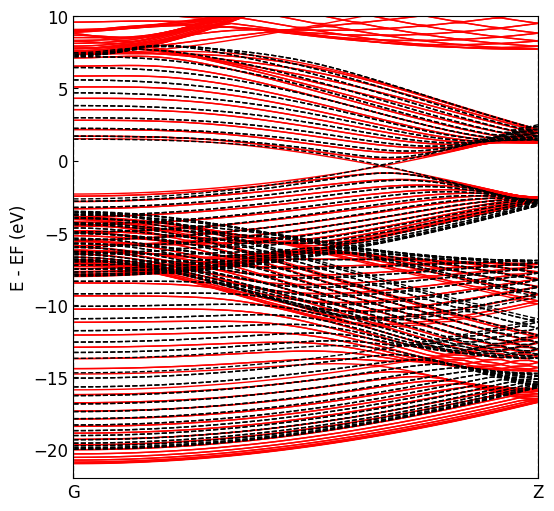

In [8]:
checkfile = '/data/results-v1.0.0/Graphene/skparam/checkpoint/latest_nnsk_c3.0w0.01.json'
#checkfile = "./inputSiGe.json"
nnskapi = NNSKHost(checkpoint=checkfile, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')
run_opt={"structure":"/data/DFT/CNT/CNT60/CNT60.vasp",
        "results_path":"./"}
jdata={
        "kline_type":"abacus",
        "kpath":[[0.0000000000, 0.0000000000, 0.0000000000, 50],
                 [0.0000000000, 0.0000000000, 0.5000000000, 1]
                 ],
        "klabels":['G','Z'],
        "emin":-10,
        "emax":10
        }
bcalc = bandcalc(apiHrk=nnHrk,run_opt=run_opt,jdata=jdata)
eigenstatus = bcalc.get_bands()

band = np.loadtxt('/data/DFT/CNT/CNT60/OUT.ABACUS/BANDS_1.dat')

plt.figure(figsize=(6,6),dpi=100)
#plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues'] - eigenstatus['E_fermi'], 'r-',lw=1)
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues'][:,:] - eigenstatus['eigenvalues'][:,:].min()-20-1, 'r-',lw=1)
# plt.plot(band['xcoords'],band['eigenvalues']-np.min(band['eigenvalues']),'k--',ms=2)
plt.plot(eigenstatus['xlist'], band[:,2:] - np.min(band[:,2:])-20,'k--',lw=1)
plt.ylim(-22,10)
# plt.axhline(-8.35)


for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
#plt.ylim(emin,emax)

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
#plt.savefig(f'{self.results_path}/band.png',dpi=300)
# plt.axhline(40.0)
plt.show()

# Compute Transmission

In [1]:
jdata = {
        "task": "negf",
        "scf": True,
        "ele_T": 500,
        "unit": "Hartree",
        "read_HS":True,
        "scf_options":{
            "mode": "PDIIS",
            "mixing_period": 3,
            "step_size": 0.05,
            "n_history": 6,
            "abs_err": 1e-6,
            "rel_err": 1e-4,
            "max_iter": 100
        },
        "stru_options":{
            "pbc":[False, False, False],
            "device":{
                "id":"0-160",
                "sort": True
            },
            "lead_L":{
                "id":"160-320",
                "voltage":0.0
            },
            "lead_R":{
                "id":"320-480",
                "voltage":0.0
            },
            "d_trains":"z"
        },
        "poisson_options": {
            "solver": "fmm",
            "err": 1e-5
        },
        "sgf_solver": "Sancho-Rubio",
        "espacing": 0.05,
        "emin": -3,
        "emax": 3,
        "e_fermi": -8.35,
        "eta_lead":1e-5,
        "eta_device":0.0,
        "properties":["DOS", "TC", "density"]
}

In [2]:
!export PYTHONUNBUFFERED=1
crt = './best_nnsk_c3.0w0.01.json'

nnskapi = NNSKHost(checkpoint=crt, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

atom = read("./C.vasp")

run_opt={"structure":atom,
        "results_path":"./"}


negf = NEGF(apiHrk=nnHrk, run_opt=run_opt, jdata=jdata)

NameError: name 'NNSKHost' is not defined

In [ ]:
negf.compute_electrode_self_energy()

True

In [6]:
negf.compute_green_function()

True

In [7]:
gtrains = [i[0] for i in negf.green]

TT = []
for i in range(120):
    TT.append(negf.calTT(
        seL=negf.SeE["lead_L"][i],
        seR=negf.SeE["lead_R"][i],
        gtrains=gtrains[i]
    ).data)

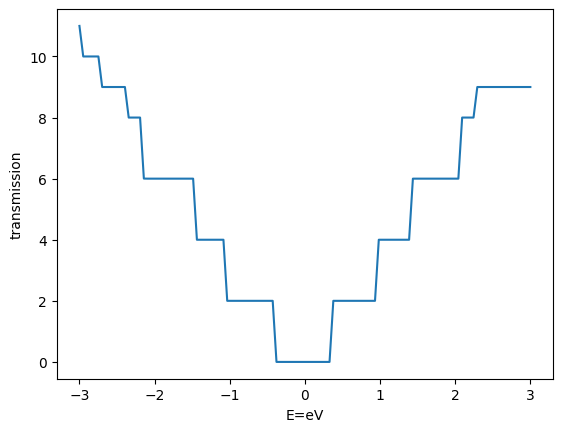

In [8]:

plt.plot(torch.linspace(-3,3,120), TT)
plt.xlabel("E=eV")
plt.ylabel("transmission")
plt.show()

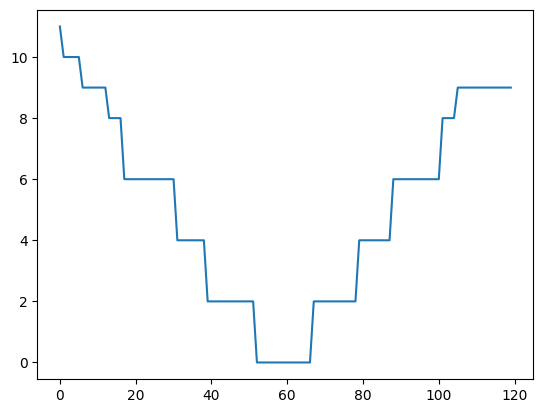

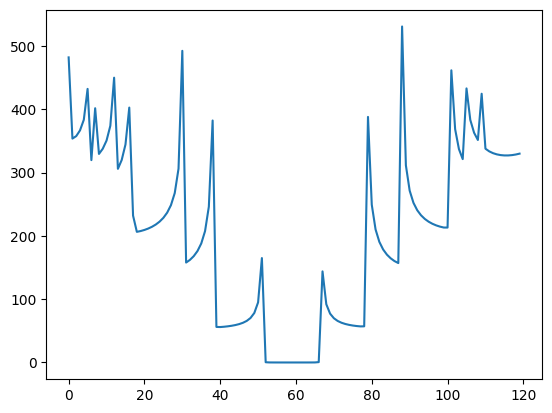

In [6]:
import torch

f=  torch.load("calc/results/properties.pth")
TC = torch.tensor(f["TC"])
import matplotlib.pyplot as plt

plt.plot(TC)
plt.show()

DOS = torch.tensor(f["DOS"])

plt.plot(DOS)
plt.show()

In [1]:
jdata = {
        "task": "negf",
        "scf": True,
        "block_tridiagonal": False,
        "ele_T": 500,
        "unit": "Hartree",
        "scf_options":{
            "mode": "PDIIS",
            "mixing_period": 3,
            "step_size": 0.05,
            "n_history": 6,
            "abs_err": 1e-6,
            "rel_err": 1e-4,
            "max_iter": 100
        },
        "stru_options":{
            "kmesh":[1,1,1],
            "pbc":[False, False, False],
            "device":{
                "id":"0-160",
                "sort": True
            },
            "lead_L":{
                "id":"160-320",
                "voltage":0.0
            },
            "lead_R":{
                "id":"320-480",
                "voltage":0.0
            }
        },
        "poisson_options": {
            "solver": "fmm",
            "err": 1e-5
        },
        "sgf_solver": "Sancho-Rubio",
        "espacing": 0.05,
        "emin": -3,
        "emax": 3,
        "e_fermi": -8.35,
        "M_cut": 50,
        "eta_lead":1e-5,
        "eta_device":0.0,
        "properties":["DOS", "TC", "density"]
}

In [2]:
from dptb.negf.hamiltonian import Hamiltonian
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.plugins.init_dptb import InitDPTBModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost, DPTBHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
from ase.io.trajectory import Trajectory
import pickle as pickle
#"seed": 3982377700,
from dptb.postprocess.NEGF import NEGF

!export PYTHONUNBUFFERED=1
crt = './best_nnsk_c3.0w0.01.json'

nnskapi = NNSKHost(checkpoint=crt, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

atom = read("./C.vasp")

h = Hamiltonian(apiH=nnHrk, structase=atom, stru_options=jdata["stru_options"], result_path="./refactor")

with torch.no_grad():
    struct_device, struct_leads = h.initialize(kpoints=[[0,0,0]])

# initial rotate H or S func.


In [3]:
from dptb.negf.Device import Device
from dptb.negf.Lead import Lead

device = Device(h, struct_device, result_path="./refactor/", efermi=jdata["e_fermi"])
device.set_leadLR(
    lead_L=Lead(hamiltonian=h, tab="lead_L", structure=struct_leads["lead_L"], result_path="./refactor/", efermi=jdata["e_fermi"], voltage=jdata["stru_options"]["lead_L"]["voltage"]),
    lead_R=Lead(hamiltonian=h, tab="lead_R", structure=struct_leads["lead_R"], result_path="./refactor/", efermi=jdata["e_fermi"], voltage=jdata["stru_options"]["lead_R"]["voltage"])
    )

In [4]:
ee = torch.linspace(-2,2,80)
with torch.no_grad():
    device.lead_L.self_energy(kpoint=[0,0,0], ee=ee, eta_lead=1e-5)
    device.lead_R.self_energy(kpoint=[0,0,0], ee=ee, eta_lead=1e-5)
    device.green_function(ee=ee, kpoint=[0,0,0], block_tridiagonal=False, etaDevice=1e-5)


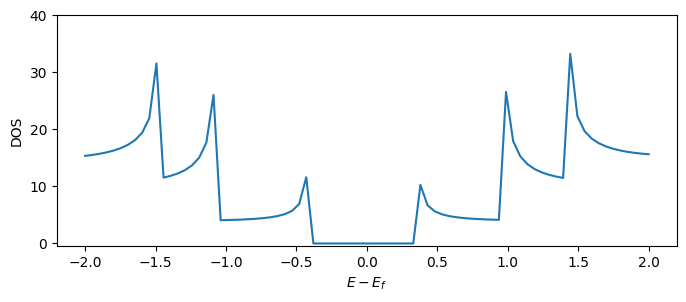

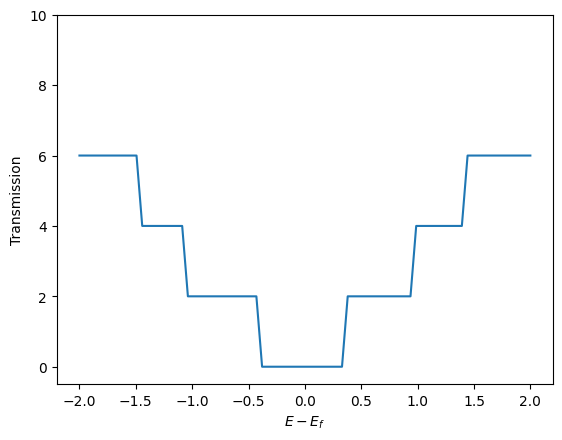

In [13]:
fig = plt.figure(figsize=(8,3))
plt.plot(ee.detach(), device.dos.detach().numpy())
plt.ylim([-0.5,40])
plt.xlabel(r"$E-E_f$")
plt.ylabel("DOS")
plt.show()

plt.plot(ee.detach(), device.tc.detach().numpy())
plt.ylim([-0.5,10])
plt.xlabel(r"$E-E_f$")
plt.ylabel("Transmission")
plt.show()

In [51]:
import matplotlib.pyplot as plt
from scipy.integrate import simpson

from dptb.negf.utils import write_vesta_lcurrent
import numpy as np
import ase.io as io
import torch

# device.structure.write("test_lc.vasp")

write_vesta_lcurrent(positions=device.structure.positions, vesta_file="./test_lc.vesta", lcurrent=device.lcurrent, current=10*np.abs(device.lcurrent)[np.abs(device.lcurrent)>1e-5].mean())

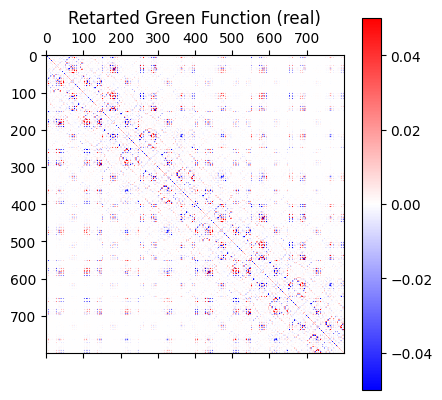

In [93]:
plt.matshow(device.grd[0][0].real.resolve_neg(), cmap="bwr", vmax=0.05, vmin=-0.05)
plt.title("Retarted Green Function (real)")
plt.colorbar()

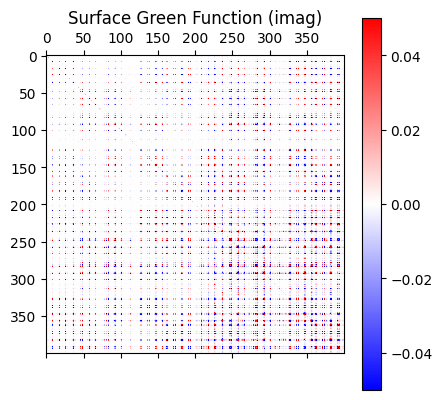

In [101]:
plt.matshow(device.lead_L.gf[0].imag, cmap="bwr", vmax=0.05, vmin=-0.05)
plt.title("Surface Green Function (imag)")
plt.colorbar()

In [5]:
from dptb.negf.density import Ozaki

ozaki = Ozaki(R=1e+6,  M_cut=50, n_gauss=50)
# DM_eq, DM_neq = ozaki.integrate(device=device, kpoint=[0,0,0])

# ldos = device.ldos

In [15]:
d_l = []
for i in range(80):
    density = ozaki.get_density_onsite(device=device, DM=ldos[i])
    d_l.append(density)

d_l = torch.stack(d_l)

Text(0.5, 1.0, 'Density Matrix')

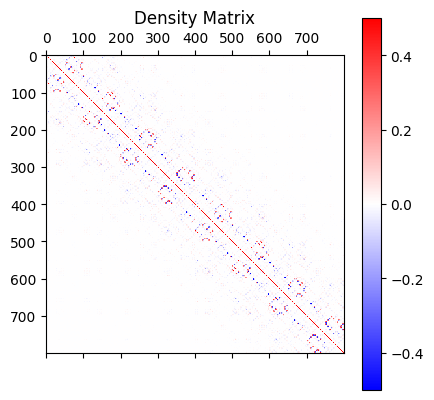

In [21]:
# DM_eq, DM_neq = ozaki.integrate(device=device, kpoint=[0,0,0])
plt.matshow(DM_eq, cmap="bwr", vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title("Density Matrix")

In [63]:
print(DM_eq)

tensor([[ 1.1930e+00, -1.5658e-02,  9.3030e-04,  ..., -3.4832e-06,
          1.5230e-04,  8.7883e-06],
        [-1.5658e-02,  1.0005e+00, -1.4982e-02,  ..., -1.4131e-04,
          1.9334e-03,  1.1834e-04],
        [ 9.3030e-04, -1.4982e-02,  8.8062e-01,  ...,  2.1085e-06,
         -9.1103e-05, -4.7247e-06],
        ...,
        [-3.4832e-06, -1.4131e-04,  2.1085e-06,  ...,  8.8062e-01,
         -8.8051e-03,  8.4564e-04],
        [ 1.5230e-04,  1.9334e-03, -9.1103e-05,  ..., -8.8051e-03,
          9.2442e-01,  4.1224e-03],
        [ 8.7883e-06,  1.1834e-04, -4.7247e-06,  ...,  8.4564e-04,
          4.1224e-03,  4.1569e-02]], dtype=torch.float64)


Text(0.5, 1.0, 'Local Current')

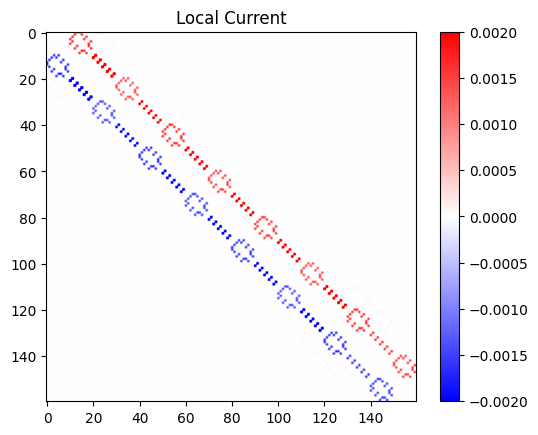

In [56]:
plt.imshow(device.lcurrent, cmap="bwr", vmax=0.002, vmin=-0.002)
plt.colorbar()
plt.title("Local Current")



Text(0, 0.5, 'LDOS per atom')

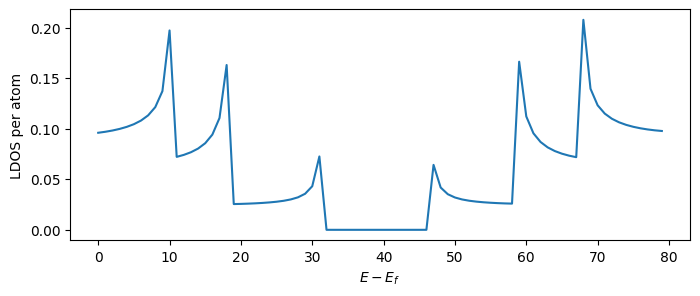

In [26]:
fig = plt.figure(figsize=(8,3))
plt.plot(d_l[:,1,3])
plt.xlabel(r"$E-E_f$")
plt.ylabel("LDOS per atom")

In [34]:
density = ozaki.get_density_onsite(device=device, DM=DM_eq)

/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


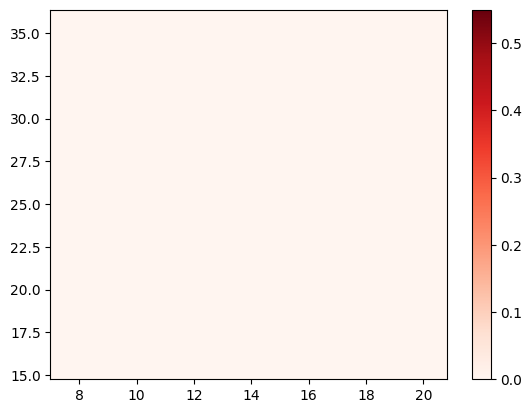

In [7]:
X,Y,data = ozaki.slice(device=device, density=density, fix_dim="y", vslice=12.5, h=0.01, sigma=0.6, plot=True, optimize = True)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import matplotlib as mpl

# plt.contour(X, Y, data.reshape(len(X), len(Y)), colors='black')

ims = []
fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(8,20), ylim=(8,20))
Xs, Ys, Zs = [], [], []
for i,v in tqdm(enumerate(range(100,601))):
    X, Y, data = ozaki.slice(device=device, density=torch.cat([torch.from_numpy(device.structure.positions), DM_eq.diag().reshape(160,5,1).sum(1)], dim=1), fix_dim="z", vslice=25+i*0.005, h=0.05, sigma=0.6)
    Xs.append(X), Ys.append(Y), Zs.append(data.reshape(len(X), len(Y)).T)
Zs = torch.stack(Zs)
ma = Zs.max()
mi = Zs.min()
norm = mpl.colors.Normalize(vmin=mi, vmax=ma)
def animate(i):
    cont = plt.pcolor(Xs[i], Ys[i], Zs[i], cmap='Reds', norm=norm)
    return cont

ani = animation.FuncAnimation(fig, animate, frames=501,interval=50, repeat_delay=500)
ani.save("./scan/test.gif")
    # plt.savefig("density_z{0}.png".format(i+1), dpi=100)
    # plt.close()

0it [00:00, ?it/s]

/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
501it [04:28,  1.86it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 

In [9]:
ma = Zs.max()
mi = Zs.min()
norm = mpl.colors.Normalize(vmin=mi, vmax=ma)
def animate(i):
    cont = plt.pcolor(Xs[i], Ys[i], Zs[i], cmap='Reds', norm=norm)
    return cont

ani = animation.FuncAnimation(fig, animate, frames=501,interval=50, repeat_delay=500)
ani.save("./scan/test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


: 

: 

MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 

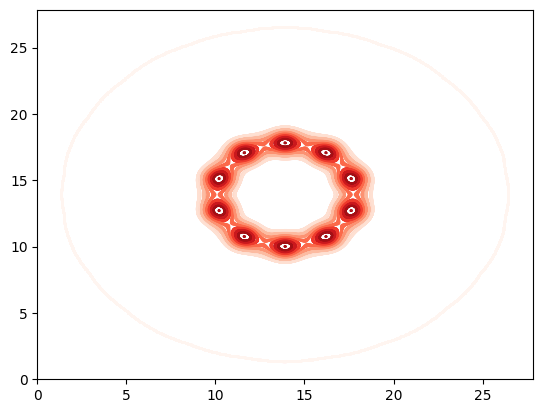

In [6]:
ani = animation.FuncAnimation(fig, animate, frames=401,interval=50, repeat_delay=500)
ani.save("./scan/test.gif")

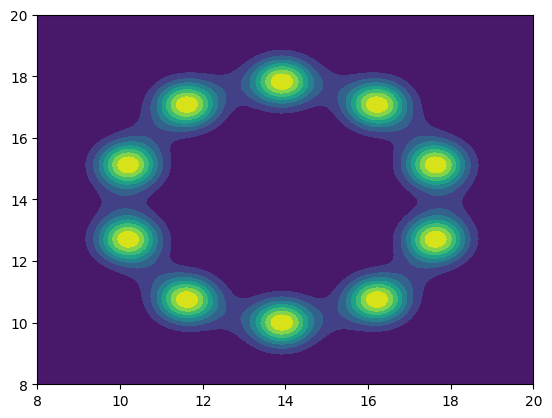

In [61]:

a = ax.contourf(X, Y, data.reshape(len(X), len(Y)).T)
a

In [9]:
print(data)

tensor([inf], dtype=torch.float64)


In [63]:
import torch
import matplotlib.pyplot as plt

def gaussian_fn(x, sigma):
    return (2*3.1415926*sigma)**-0.5 * torch.exp(-(x**2).sum()/2/sigma**2)

def field(x,y, sigma):
    fn_list = []
    for position, value in zip(x,y):
        fn_list.append(lambda p: (position, value * gaussian_fn(torch.tensor(p)-position.clone(), sigma)))

    field_fn = lambda p: torch.stack([i(p) for i in fn_list])
    
    return fn_list





In [64]:
density = torch.tensor([[-0.5,-0.5,0,0.2],[1/2,1/2,0,0.2]])

fd = field(x=density[:,:3], y=density[:,-1], sigma=0.4)

fd[0](torch.tensor([0.2,-0.5,0])), fd[1](torch.tensor([0.2,-0.5,0]))

/tmp/ipykernel_7483/3233304266.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fn_list.append(lambda p: (position, value * gaussian_fn(torch.tensor(p)-position.clone(), sigma)))


((tensor([0.5000, 0.5000, 0.0000]), tensor(0.0042)),
 (tensor([0.5000, 0.5000, 0.0000]), tensor(0.0042)))

In [39]:
density = torch.tensor([[-0.5,-0.5,0,0.2],[1/2,1/2,0,0.2]])

fd = field(x=density[:,:3], y=density[:,-1], sigma=0.4)
print(fd(torch.tensor([0.2,-0.5,0])))


# mesh = torch.stack(torch.meshgrid(torch.arange(-2,2,0.05), torch.arange(-2,2,0.05), torch.scalar_tensor(0.))).squeeze(-1).permute(1,2,0).reshape(-1,3)

# v = []
# for i in mesh:
#     v.append(fd(i))

# v = torch.tensor(v)
# print(v)

<function field.<locals>.<lambda> at 0x7f6c3d945e50>
tensor([0.0042, 0.0042])


/tmp/ipykernel_7483/2652500429.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fn_list.append(lambda p: value * gaussian_fn(torch.tensor(p)-position.clone(), sigma))


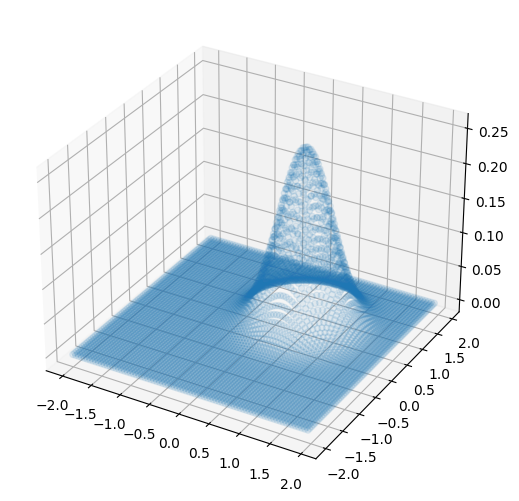

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(mesh[:,0].numpy(), mesh[:,1].numpy(), v.numpy(), alpha=0.1)
plt.show()

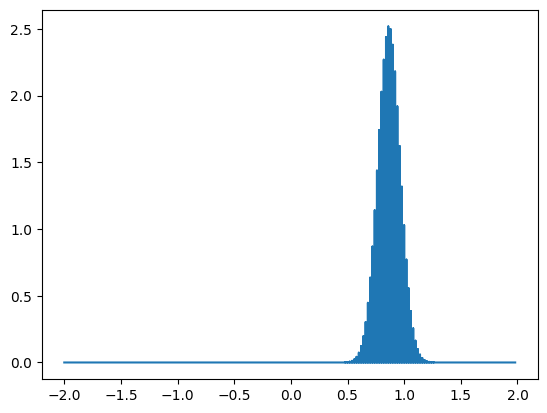

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.neighborlist

fig = plt.figure()
plt.plot(mesh[:,0].numpy(), v.numpy())
plt.show()
